In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import re
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from frame_collector import FrameCollector

In [2]:
ENDPOINT = "http://data.memad.eu/sparql-endpoint"
sparql = SPARQLWrapper(ENDPOINT)
sparql.setReturnFormat(JSON)

In [3]:
with open('memad_people_part.rq') as file:
    query = file.read()

sparql.setQuery(query)
people = sparql.query().convert()["results"]["bindings"]
for x in people:
    for k in x:
        x[k] = x[k]['value']
df_people = pd.DataFrame.from_dict(people)
df_people['nb'] = df_people['nb'].apply(pd.to_numeric)
df_people

,g,c,label,nb
0,http://data.memad.eu/graph/ina-pa,http://data.memad.eu/agent/rincquesen-nathanae...,"Rincquesen, Nathanaël de",172
1,http://data.memad.eu/graph/ina-ld,http://data.memad.eu/agent/rincquesen-nathanae...,"Rincquesen, Nathanaël de",172
2,http://data.memad.eu/graph/ina-ld,http://data.memad.eu/agent/lucet-elise,"Lucet, Elise",135
3,http://data.memad.eu/graph/ina-pa,http://data.memad.eu/agent/lucet-elise,"Lucet, Elise",135
4,http://data.memad.eu/graph/ina-pa,http://data.memad.eu/agent/le-saint-sophie,"Le Saint, Sophie",55
...,...,...,...,...
962,http://data.memad.eu/graph/ina-ld,http://data.memad.eu/agent/merah-zoulikha,"Merah, Zoulikha",1
963,http://data.memad.eu/graph/ina-ld,http://data.memad.eu/agent/grappe-frederic,"Grappe, Frédéric",1
964,http://data.memad.eu/graph/ina-ld,http://data.memad.eu/agent/dardenne-luc,"Dardenne, Luc",1
965,http://data.memad.eu/graph/ina-ld,http://data.memad.eu/agent/dugarry-christophe,"Dugarry, Christophe",1


Select top 6 celebrities

In [4]:
people_uri = []
people_labels = []
iterator = df_people.itertuples()
while len(people_uri) < 6:
    p = next(iterator)
    if p.c not in people_uri:
        people_uri.append(p.c)
        people_labels.append(p.label)
list(zip(people_uri, people_labels))

[('http://data.memad.eu/agent/rincquesen-nathanael-de',
  'Rincquesen, Nathanaël de'),
 ('http://data.memad.eu/agent/lucet-elise', 'Lucet, Elise'),
 ('http://data.memad.eu/agent/le-saint-sophie', 'Le Saint, Sophie'),
 ('http://data.memad.eu/agent/delahousse-laurent', 'Delahousse, Laurent'),
 ('http://data.memad.eu/agent/gastrin-sophie', 'Gastrin, Sophie'),
 ('http://data.memad.eu/agent/drucker-marie', 'Drucker, Marie')]

In [5]:
with open('memad_parts_by_person.rq') as file:
    query = file.read()

In [6]:
from src.utils.media_fragment import convert_to_seconds_npt
def pad_spaces(text):
    pad = 25 - len(text)
    return text + ''.join([' ' for _ in range(0,pad)])
    
def get_segments(person, name):
    q = query.replace('?person', '<%s>' % person)
    sparql.setQuery(q)
    results = sparql.query().convert()["results"]["bindings"]
    for r in results:
        for p in r:
            value = r[p]['value']
            if p in ['start', 'end']:
                value = convert_to_seconds_npt(re.sub(r"T(\d{2}:\d{2}:\d{2}).+", "\g<1>", value))
            if p == 'prop':
                value = re.split(r"[/#]", value)[-1]
            r[p] = value
        r['person'] = name
        r['person_uri'] = person
    
    results = [r for r in results if 'start' in r and r['start'] < r['end']]
    print('- %s\t%s'%(pad_spaces(name), len(results)))
    
    
    return pd.DataFrame.from_dict(results) 

print('Num. results per person:')
df = pd.concat([get_segments(uri, name) 
                     for uri, name in tqdm(zip(people_uri, people_labels), total=len(people_uri))],
               ignore_index=True)
df

Num. results per person:


- Rincquesen, Nathanaël de 	172
- Lucet, Elise             	142
- Le Saint, Sophie         	55
- Delahousse, Laurent      	44
- Gastrin, Sophie          	39
- Drucker, Marie           	79



,p,media,start,end,locator,person,person_uri
0,http://data.memad.eu/fr2/7h00-le-journal/107a2...,http://data.memad.eu/fr2/7h00-le-journal/11c0b...,158.0,188.0,https://platform.limecraft.com/api/production/...,"Rincquesen, Nathanaël de",http://data.memad.eu/agent/rincquesen-nathanae...
1,http://data.memad.eu/fr2/7h00-le-journal/1890a...,http://data.memad.eu/fr2/7h00-le-journal/11c0b...,22.0,74.0,https://platform.limecraft.com/api/production/...,"Rincquesen, Nathanaël de",http://data.memad.eu/agent/rincquesen-nathanae...
2,http://data.memad.eu/fr2/7h00-le-journal/1d8ce...,http://data.memad.eu/fr2/7h00-le-journal/11c0b...,242.0,245.0,https://platform.limecraft.com/api/production/...,"Rincquesen, Nathanaël de",http://data.memad.eu/agent/rincquesen-nathanae...
3,http://data.memad.eu/fr2/7h00-le-journal/21ac2...,http://data.memad.eu/fr2/7h00-le-journal/11c0b...,476.0,506.0,https://platform.limecraft.com/api/production/...,"Rincquesen, Nathanaël de",http://data.memad.eu/agent/rincquesen-nathanae...
4,http://data.memad.eu/fr2/7h00-le-journal/43b30...,http://data.memad.eu/fr2/7h00-le-journal/11c0b...,188.0,209.0,https://platform.limecraft.com/api/production/...,"Rincquesen, Nathanaël de",http://data.memad.eu/agent/rincquesen-nathanae...
...,...,...,...,...,...,...,...
526,http://data.memad.eu/fr2/20-heures/f7f9040681d...,http://data.memad.eu/fr2/20-heures/68bd349849e...,2186.0,2203.0,https://platform.limecraft.com/api/production/...,"Drucker, Marie",http://data.memad.eu/agent/drucker-marie
527,http://data.memad.eu/fr2/20-heures/cfe1c51a95a...,http://data.memad.eu/fr2/20-heures/55e49abf526...,544.0,561.0,https://platform.limecraft.com/api/production/...,"Drucker, Marie",http://data.memad.eu/agent/drucker-marie
528,http://data.memad.eu/fr2/20-heures/f7f9040681d...,http://data.memad.eu/fr2/20-heures/68bd349849e...,2185.0,2204.0,https://platform.limecraft.com/api/production/...,"Drucker, Marie",http://data.memad.eu/agent/drucker-marie
529,http://data.memad.eu/fr2/20-heures/f7f9040681d...,http://data.memad.eu/fr2/20-heures/68bd349849e...,2186.0,2204.0,https://platform.limecraft.com/api/production/...,"Drucker, Marie",http://data.memad.eu/agent/drucker-marie


Some media are repeated

In [7]:
df['media'].value_counts()

http://data.memad.eu/fr2/20-heures/68bd349849eaaeaa3986725f4b0533b63327e23b          41
http://data.memad.eu/fr2/13-heures/f0c2067e0351dd639fcdf0843e4fedf1886be320          29
http://data.memad.eu/fr2/13-heures/312f56e3ca31ea7ab20b540d127830a0ccf9d591          25
http://data.memad.eu/fr2/20-heures/55e49abf5266c5f0942b53b547a2c290693b5dfb          25
http://data.memad.eu/fr2/13-heures/b8919ac070443f2b9482f3f577ea7af34c04e6f4          23
http://data.memad.eu/fr2/13-heures/72322c5279865668cc4d5c9ff1d7646366939f6a          22
http://data.memad.eu/fr2/13-heures/ba98967dff964c47c89ba23d187dd241aaa28b55          22
http://data.memad.eu/fr2/20-heures/bc94cb0df1a39668823168bae83067b81f5d5a28          22
http://data.memad.eu/fr2/13-heures/dd5bc1b8a44809fb736ac6fbbf21a257abaef046          21
http://data.memad.eu/fr2/8h00-le-journal/92c68cd73e858dea2f7fb32ab94dc6b6d3dd0fbf    19
http://data.memad.eu/fr2/13-heures/3ac1dfecf3092bedab3ef74252ceb05f572d2269          18
http://data.memad.eu/fr2/7h00-le

In [8]:
df['p'].value_counts()

http://data.memad.eu/fr2/20-heures/8e091b64bcd316b068f30e42c69bab89bf4a4d85          4
http://data.memad.eu/fr2/20-heures/632223105927ac0bca2fd5d2af6a8a4ab17e7b35          4
http://data.memad.eu/fr2/20-heures/341912ffa39e2082cdb4d280dab0ac401aa37ba2          4
http://data.memad.eu/fr2/20-heures/f7f9040681d94f67f69cf0ddb00dfa3bc763ca95          4
http://data.memad.eu/fr2/20-heures/c34e177f830a029e2c8456644d08ce2de28ba154          4
                                                                                    ..
http://data.memad.eu/fr2/8h00-le-journal/a928c7a6d6719d5385614f0bf164a64e8e1a0982    1
http://data.memad.eu/fr2/7h00-le-journal/281746dd802ed78623391b3668dca5569487e287    1
http://data.memad.eu/fr2/13-heures/63fbd6c78d247a7f7b969ecaba6b4b2e74655f84          1
http://data.memad.eu/fr2/7h00-le-journal/58fb2156d600479af85a0a311640e0631a764d88    1
http://data.memad.eu/fr2/13-heures/1abec2cd8a0cf56192f7205cde92e136ddeb56a1          1
Name: p, Length: 476, dtype: int64

In [9]:
df['duration'] = df['end'] - df['start']
df['duration'].describe()

count    531.000000
mean      61.361582
std       69.655034
min        1.000000
25%       20.000000
50%       49.000000
75%       74.000000
max      585.000000
Name: duration, dtype: float64

Given that they are not divided in shots, I would focus on the shortest ones

In [10]:
df_subset = df[df['duration'] < 120]
print('Subset length: %d' %len(df_subset))

df_subset['person_uri'].value_counts()

Subset length: 483


http://data.memad.eu/agent/rincquesen-nathanael-de    172
http://data.memad.eu/agent/lucet-elise                103
http://data.memad.eu/agent/drucker-marie               75
http://data.memad.eu/agent/le-saint-sophie             55
http://data.memad.eu/agent/gastrin-sophie              39
http://data.memad.eu/agent/delahousse-laurent          39
Name: person_uri, dtype: int64

In [32]:
from src.connectors import memad_connector as memad
from src.connectors import limecraft_connector as limecraft

old_loc = ''
fc = None

df_subset.sort_values(by='media', ascending=False)

table = df_subset

def ex_frame(row):
    global fc
    global old_loc
    
    loc = memad.get_locator_for(row['media'])
    if not loc:
        print('No loc for: '+ row['media'])
        return 0
    
    loc = limecraft.locator2video(loc['locator']['value'])
    if loc != old_loc:
        fc = FrameCollector(loc, 'memad_gt', id=row['media'])
        old_loc = loc
    
    start = row['start']
    end = row['end']
    duration = end - start
    quarter = int(duration / 4)
    quarter1 = start + quarter 
    center = start + quarter * 2
    quarter2 = start + quarter * 3
    
    try:
        x = fc.run(frame_no=quarter1)
        if x == 0:
            x = fc.run(frame_no=center)
        if x == 0:
            x = fc.run(frame_no=quarter2)
        return x
    except:
        print('Error: ' + loc)
        return 0

frames = [ex_frame(row) for idx, row in tqdm(table.iterrows(), total=len(table))]

In [33]:
frames = [l if l is not None else 0 for l in frames]
frames

['./frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_165.jpg',
 './frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_35.jpg',
 './frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_242.jpg',
 './frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_483.jpg',
 './frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_193.jpg',
 './frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_344.jpg',
 './frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_453.jpg',
 0,
 './frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_217.jpg',
 './frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_513.jpg',
 './frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_660.jpg',
 './frames/memad_gt/7h00-le-journal_11c0beb19cddc328195dc91f781280d013756b6b_405.jpg',
 './frames/memad_gt/7h00-le-journal_11c0

In [34]:
df_subset = df_subset.reset_index(drop=True)

df_subset['frame'] = frames
df_extracted = df_subset[df_subset['frame'] != 0]
df_extracted

,p,media,start,end,locator,person,person_uri,duration,frame
0,http://data.memad.eu/fr2/7h00-le-journal/107a2...,http://data.memad.eu/fr2/7h00-le-journal/11c0b...,158.0,188.0,https://platform.limecraft.com/api/production/...,"Rincquesen, Nathanaël de",http://data.memad.eu/agent/rincquesen-nathanae...,30.0,./frames/memad_gt/7h00-le-journal_11c0beb19cdd...
1,http://data.memad.eu/fr2/7h00-le-journal/1890a...,http://data.memad.eu/fr2/7h00-le-journal/11c0b...,22.0,74.0,https://platform.limecraft.com/api/production/...,"Rincquesen, Nathanaël de",http://data.memad.eu/agent/rincquesen-nathanae...,52.0,./frames/memad_gt/7h00-le-journal_11c0beb19cdd...
2,http://data.memad.eu/fr2/7h00-le-journal/1d8ce...,http://data.memad.eu/fr2/7h00-le-journal/11c0b...,242.0,245.0,https://platform.limecraft.com/api/production/...,"Rincquesen, Nathanaël de",http://data.memad.eu/agent/rincquesen-nathanae...,3.0,./frames/memad_gt/7h00-le-journal_11c0beb19cdd...
3,http://data.memad.eu/fr2/7h00-le-journal/21ac2...,http://data.memad.eu/fr2/7h00-le-journal/11c0b...,476.0,506.0,https://platform.limecraft.com/api/production/...,"Rincquesen, Nathanaël de",http://data.memad.eu/agent/rincquesen-nathanae...,30.0,./frames/memad_gt/7h00-le-journal_11c0beb19cdd...
4,http://data.memad.eu/fr2/7h00-le-journal/43b30...,http://data.memad.eu/fr2/7h00-le-journal/11c0b...,188.0,209.0,https://platform.limecraft.com/api/production/...,"Rincquesen, Nathanaël de",http://data.memad.eu/agent/rincquesen-nathanae...,21.0,./frames/memad_gt/7h00-le-journal_11c0beb19cdd...
...,...,...,...,...,...,...,...,...,...
477,http://data.memad.eu/fr2/20-heures/f7f9040681d...,http://data.memad.eu/fr2/20-heures/68bd349849e...,2185.0,2203.0,https://platform.limecraft.com/api/production/...,"Drucker, Marie",http://data.memad.eu/agent/drucker-marie,18.0,./frames/memad_gt/20-heures_68bd349849eaaeaa39...
478,http://data.memad.eu/fr2/20-heures/f7f9040681d...,http://data.memad.eu/fr2/20-heures/68bd349849e...,2186.0,2203.0,https://platform.limecraft.com/api/production/...,"Drucker, Marie",http://data.memad.eu/agent/drucker-marie,17.0,./frames/memad_gt/20-heures_68bd349849eaaeaa39...
480,http://data.memad.eu/fr2/20-heures/f7f9040681d...,http://data.memad.eu/fr2/20-heures/68bd349849e...,2185.0,2204.0,https://platform.limecraft.com/api/production/...,"Drucker, Marie",http://data.memad.eu/agent/drucker-marie,19.0,./frames/memad_gt/20-heures_68bd349849eaaeaa39...
481,http://data.memad.eu/fr2/20-heures/f7f9040681d...,http://data.memad.eu/fr2/20-heures/68bd349849e...,2186.0,2204.0,https://platform.limecraft.com/api/production/...,"Drucker, Marie",http://data.memad.eu/agent/drucker-marie,18.0,./frames/memad_gt/20-heures_68bd349849eaaeaa39...


In [35]:
df_extracted['person'].value_counts()

Rincquesen, Nathanaël de    125
Lucet, Elise                 62
Drucker, Marie               56
Le Saint, Sophie             35
Gastrin, Sophie              30
Delahousse, Laurent          27
Name: person, dtype: int64

In [36]:
df_extracted.to_csv(r'memad_parts.csv', index = False)

In [ ]:
df_extracted = pd.read_csv('memad_parts.csv')
df_extracted

In [13]:
duration_query = '''  
SELECT SAMPLE(?duration) as ?duration WHERE {
    ?p a ebucore:TVProgramme ;
        ebucore:duration ?duration }
'''
overflowing = []
for i, x in tqdm(df_extracted.iterrows(), total=len(df_extracted)):
    sparql.setQuery(duration_query.replace('?p', f'<{x["media"]}>'))
    res = sparql.query().convert()["results"]["bindings"]
    duration = float(res[0]['duration']['value'])
    overflowing.append(x['end'] > duration)
df_extracted['overflowing'] = overflowing

### Plan

1. Extract 1 folders for each person
2. Manually remove the ones not containing the person
3. Re-import in this notebook and fix the table

##### 1. Extract 3 folders for each person

In [49]:
from shutil import copyfile

for p in df_extracted['person'].unique():
    out_path = './dataset_memad/%s' % p.replace(' ', '_')
    os.makedirs(out_path, exist_ok=True)

    for i, row in df_extracted[df_extracted['person'] == p].iterrows():
        x = row['frame']
        fname = x.split('/')[-1]
        copyfile(x, os.path.join(out_path, fname))

##### 2. Manually move those to 2 groups: containing and not containing the person


_(This action is made offline)_

##### 3. Re-import in this notebook and fix the table

In [5]:
manual_good = []
manual_bad = []
for p in os.listdir('./dataset_memad'):
    if p == '.DS_Store':
        continue
        

    for f in os.listdir(os.path.join('./dataset_memad', p)):
        if f == '.DS_Store':
            continue
        if p == 'unknown':
            manual_bad.append('./frames/memad_gt/'+f)
        else:
            manual_good.append((p,'./frames/memad_gt/'+f))

In [6]:
unique, counts = np.unique(np.array(manual_good)[:,0], return_counts=True)
for a,b in zip(unique,counts):
    print(a, b)

Delahousse,_Laurent 10
Drucker,_Marie 18
Gastrin,_Sophie 25
Le_Saint,_Sophie 26
Lucet,_Elise 28
Rincquesen,_Nathanaël_de 65


In [30]:
to_take = []
for p in unique:
    g = [b for a,b in manual_good if a == p]
    g = [b for b in g if df_extracted[df_extracted['frame']==b]['overflowing'].iloc[0] == False]
    to_take = np.append(to_take, np.random.choice(g, size=np.min([len(g),10]), replace=False))
# valid_shots[valid_shots.person.str.contains('Mitterrand')][valid_shots.confidence > 0.4]

In [31]:
tot_segments = len(np.unique(to_take))
tot_segments

55

We want to arrive to 100 with segments without known people

In [32]:
tot_unknown = 100 - tot_segments
tot_unknown

45

In [33]:
dataset = []
for p, f in manual_good:
    if f not in to_take:
        continue 
    person = p.replace('_', ' ')
    row = df_extracted[df_extracted.frame == f][['media', 'locator', 'p', 'start', 'end']].iloc[0].to_dict()
    row['person'] = person
    dataset.append(row)

for f in np.random.choice(manual_bad, tot_unknown, replace=False):
    row = df_extracted[df_extracted.frame == f][['media', 'locator', 'p', 'start', 'end']].iloc[0].to_dict()
    row['person'] = 0
    dataset.append(row)

df_dataset = pd.DataFrame.from_dict(dataset)
df_dataset

,media,locator,p,start,end,person
0,http://data.memad.eu/fr2/7h30-le-journal/95864...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/7h30-le-journal/7d0d1...,462.0,487.0,"Le Saint, Sophie"
1,http://data.memad.eu/fr2/7h30-le-journal/25fd9...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/7h30-le-journal/af6f8...,358.0,421.0,"Le Saint, Sophie"
2,http://data.memad.eu/fr2/7h30-le-journal/4feee...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/7h30-le-journal/842d9...,364.0,413.0,"Le Saint, Sophie"
3,http://data.memad.eu/fr2/6h30-le-journal/0474b...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/6h30-le-journal/48865...,234.0,236.0,"Le Saint, Sophie"
4,http://data.memad.eu/fr2/6h30-le-journal/4f852...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/6h30-le-journal/498e9...,195.0,217.0,"Le Saint, Sophie"
...,...,...,...,...,...,...
95,http://data.memad.eu/fr2/13-heures/3ac1dfecf30...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/13-heures/f3a2bc632d9...,340.0,364.0,0
96,http://data.memad.eu/fr2/13-heures/f0c2067e035...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/13-heures/8311ffe9315...,925.0,968.0,0
97,http://data.memad.eu/fr2/13-heures/2c506ee4e8d...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/13-heures/9c802bb4d1c...,485.0,524.0,0
98,http://data.memad.eu/fr2/20-heures/bc94cb0df1a...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/20-heures/a1cd9fbd25b...,1761.0,1786.0,0


Representation of people in the dataset

In [34]:
df_dataset['person'].value_counts()

0                            45
Le Saint, Sophie             10
Drucker, Marie               10
Lucet, Elise                 10
Rincquesen, Nathanaël de    10
Gastrin, Sophie              10
Delahousse, Laurent           5
Name: person, dtype: int64

How much known faces we found in the same segment

In [35]:
df_dataset['p'].value_counts()

http://data.memad.eu/fr2/20-heures/a9847a680cfc4491f40ae831e4ddce5379236e9e          2
http://data.memad.eu/fr2/20-heures/cc39d21635c8a943d384dde70afebdb371fc2fe3          2
http://data.memad.eu/fr2/20-heures/c34e177f830a029e2c8456644d08ce2de28ba154          2
http://data.memad.eu/fr2/20-heures/9fc09633ea05d40826c3fe49e1028160e9384fea          2
http://data.memad.eu/fr2/20-heures/341912ffa39e2082cdb4d280dab0ac401aa37ba2          2
                                                                                    ..
http://data.memad.eu/fr2/6h30-le-journal/498e926f332cddfd8639acd97d3230c36a4390e8    1
http://data.memad.eu/fr2/7h30-le-journal/ec13d7b303640cb9f3fa8e26b624fd8b5d2bf585    1
http://data.memad.eu/fr2/13-heures/2235aab3afd0ced435f2cca4cc1c8b08aaff125e          1
http://data.memad.eu/fr2/13-heures/8311ffe93154950e83b7d2bd367d01a193e5af1b          1
http://data.memad.eu/fr2/13-heures/aa59fe47af2a17462bc03f2f56577fcc2d56048a          1
Name: p, Length: 95, dtype: int64

In [36]:
np.unique(df_dataset['p'].value_counts().to_list(), return_counts=True)

(array([1, 2]), array([90,  5]))

In [37]:
df_dataset.to_csv('dataset_memad.csv', index=False)  

In [113]:
import json

with open('results_memad_gt.json', 'r') as f:
    results = json.load(f)
len(results)

100

In [114]:
from src import clusterize

clusters = [clusterize.main(clusterize.from_dict(p), confidence_threshold=0.0) for p in results]

In [115]:
clusters[0]

[{'name': 'Le Saint, Sophie',
  'project': 'memad_gt',
  'track_id': 2,
  'confidence': 0.7211674367436585,
  'locator': 'http://data.memad.eu/fr2/7h30-le-journal/95864235796447d859f463156c86d696f3f49f88',
  'bounding': {'x': 190, 'y': 51, 'w': 72, 'h': 95, 'xywh': '190,51,72,95'},
  'rect': [190.0, 51.0, 262.0, 146.0],
  'end_sample': 9,
  'start_sample': 4,
  'end_frame': 11750,
  'start_frame': 11625,
  'end_npt': 470.0,
  'start_npt': 465.0},
 {'name': 'Le Saint, Sophie',
  'project': 'memad_gt',
  'track_id': 3,
  'confidence': 0.7256660401509842,
  'locator': 'http://data.memad.eu/fr2/7h30-le-journal/95864235796447d859f463156c86d696f3f49f88',
  'bounding': {'x': 346, 'y': 76, 'w': 50, 'h': 62, 'xywh': '346,76,50,62'},
  'rect': [346.0, 76.0, 396.0, 138.0],
  'end_sample': 17,
  'start_sample': 10,
  'end_frame': 11950,
  'start_frame': 11775,
  'end_npt': 478.0,
  'start_npt': 471.0}]

In [117]:
l = len(df_dataset)
df_dataset['predicted'] = np.zeros(l)
df_dataset['confidence'] = np.zeros(l)

for i, x in df_dataset.iterrows():
    cur = clusters[i]
    start = x['start']
    end = x['end']
    b = np.arange(start, end)
    found = False
    for c in cur:
        a = np.arange(c['start_npt'], c['end_npt'])
        if len(np.intersect1d(a,b)) > 0:
            df_dataset.loc[i, 'predicted'] = c['name']
            df_dataset.loc[i, 'confidence'] = c['confidence']

df_dataset

,media,locator,p,start,end,person,predicted,confidence
0,http://data.memad.eu/fr2/7h30-le-journal/95864...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/7h30-le-journal/7d0d1...,462.0,487.0,"Le Saint, Sophie","Le Saint, Sophie",0.725666
1,http://data.memad.eu/fr2/7h30-le-journal/25fd9...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/7h30-le-journal/af6f8...,358.0,421.0,"Le Saint, Sophie","Le Saint, Sophie",0.739454
2,http://data.memad.eu/fr2/7h30-le-journal/4feee...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/7h30-le-journal/842d9...,364.0,413.0,"Le Saint, Sophie","Le Saint, Sophie",0.709442
3,http://data.memad.eu/fr2/6h30-le-journal/0474b...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/6h30-le-journal/48865...,234.0,236.0,"Le Saint, Sophie",0,0.000000
4,http://data.memad.eu/fr2/6h30-le-journal/4f852...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/6h30-le-journal/498e9...,195.0,217.0,"Le Saint, Sophie","Le Saint, Sophie",0.717663
...,...,...,...,...,...,...,...,...
95,http://data.memad.eu/fr2/13-heures/3ac1dfecf30...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/13-heures/f3a2bc632d9...,340.0,364.0,0,"Le Saint, Sophie",0.420670
96,http://data.memad.eu/fr2/13-heures/f0c2067e035...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/13-heures/8311ffe9315...,925.0,968.0,0,"Rincquesen, Nathanaël de",0.418957
97,http://data.memad.eu/fr2/13-heures/2c506ee4e8d...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/13-heures/9c802bb4d1c...,485.0,524.0,0,0,0.000000
98,http://data.memad.eu/fr2/20-heures/bc94cb0df1a...,https://platform.limecraft.com/api/production/...,http://data.memad.eu/fr2/20-heures/a1cd9fbd25b...,1761.0,1786.0,0,"Delahousse, Laurent",0.684022


In [195]:
from sklearn.metrics import precision_recall_fscore_support as score

classes = [str(p) for p in df_dataset['person'].unique()]

def compute_metrics(threshold=0.5):
    label = np.array([str(p) for p in df_dataset['person']])
    predicted = np.array([str(p['predicted']) if p['confidence'] > threshold else '0' for i, p in df_dataset.iterrows() ])
    predicted = ['Rincquesen, Nathanaël de' if p == 'Rincquesen, Nathanaël de' else p for p in predicted]
    
    return score(label, predicted, labels=classes)

def show_metrics(threshold=0.5):
    precision , recall, fscore, support = compute_metrics(threshold)

    dfx = pd.DataFrame()
    dfx['index']= classes
    dfx['precision'] =  precision
    dfx['recall'] =  recall
    dfx['fscore'] =  fscore
    dfx['support'] =  support

    tot = {
    'index' : 'tot (excluded 0)',
    'precision': np.average(precision[0:-1], weights=support[0:-1]),
    'recall' : np.average(recall[0:-1], weights=support[0:-1]),
    'fscore' : np.average(fscore[0:-1], weights=support[0:-1]),
    'support' : np.sum(support)
    }
    dfx = dfx.append(pd.DataFrame(tot, index=[7]))
    return dfx

show_metrics()

,index,precision,recall,fscore,support
0,"Le Saint, Sophie",0.666667,0.800000,0.727273,10
1,"Delahousse, Laurent",0.428571,0.600000,0.500000,5
2,"Lucet, Elise",0.714286,0.500000,0.588235,10
3,"Gastrin, Sophie",0.857143,0.600000,0.705882,10
4,"Rincquesen, Nathanaël de",0.400000,0.800000,0.533333,10
5,"Drucker, Marie",0.600000,0.900000,0.720000,10
6,0,0.500000,0.355556,0.415584,45
7,tot (excluded 0),0.627706,0.709091,0.640859,100


In [196]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


interact(show_metrics, threshold=widgets.FloatSlider(min=0, max=1, step=0.05, value=0.60));

interactive(children=(FloatSlider(value=0.6, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

In [197]:
with open('latex.txt', 'w') as f:
    show_metrics(0.6).to_latex(f, index=False)

In [146]:
precision =[]
recall =[]
fscore =[]

_range = np.arange(0, 0.8, 0.05)
for threshold in _range:
    p, r, f, support = compute_metrics(threshold)
    precision.append(np.average(p[0:-1], weights=support[0:-1]))
    recall.append(np.average(r[0:-1], weights=support[0:-1]))
    fscore.append(np.average(f[0:-1], weights=support[0:-1]))

/Users/pasquale/opt/anaconda3/envs/facerec/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [173]:
np.argmax(fscore) * 0.05

0.55

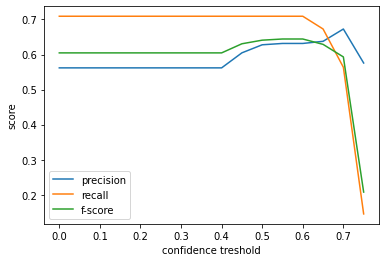

In [190]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(_range, precision, label='precision')  # Plot some data on the axes.
ax.plot(_range, recall, label='recall')  # Plot more data on the axes...
ax.plot(_range, fscore, label='f-score')  # ... and some more.
ax.set_xlabel('confidence treshold')  # Add an x-label to the axes.
ax.set_ylabel('score')  # Add a y-label to the axes.
ax.legend()  # Add a legend
plt.savefig('memad_facerec_precision.pdf')  

# Part 2: Yle

Yle has no parts

In [89]:
with open('memad_people.rq') as file:
    query = file.read()

sparql.setQuery(query)
people = sparql.query().convert()["results"]["bindings"]
for x in people:
    for k in x:
        x[k] = x[k]['value']
df_people = pd.DataFrame.from_dict(people)
df_people['nb'] = df_people['nb'].apply(pd.to_numeric)
df_people

,c,label,nb
0,http://data.memad.eu/agent/esa-saari,Esa Saari,94
1,http://data.memad.eu/agent/johan-hellman,Johan Hellman,90
2,http://data.memad.eu/agent/birgitta-norrgard,Birgitta Norrgård,89
3,http://data.memad.eu/agent/dani-stromback,Dani Strömbäck,88
4,http://data.memad.eu/agent/jussi-pernaa,Jussi Pernaa,85
...,...,...,...
1867,http://data.memad.eu/agent/riittasisko-jukkala...,Riittasisko Jukkala-Benisch,1
1868,http://data.memad.eu/agent/gunnbritt-estlander,Gunnbritt Estlander,1
1869,http://data.memad.eu/agent/reijo-leskinen,Reijo Leskinen,1
1870,http://data.memad.eu/agent/mohammed-ibrahim,Mohammed Ibrahim,1


Select top 10 celebrities

In [90]:
people_uri = []
people_labels = []
iterator = df_people.itertuples()
while len(people_uri) < 10:
    p = next(iterator)
    if p.c not in people_uri:
        people_uri.append(p.c)
        people_labels.append(p.label)
list(zip(people_uri, people_labels))

[('http://data.memad.eu/agent/esa-saari', 'Esa Saari'),
 ('http://data.memad.eu/agent/johan-hellman', 'Johan Hellman'),
 ('http://data.memad.eu/agent/birgitta-norrgard', 'Birgitta Norrgård'),
 ('http://data.memad.eu/agent/dani-stromback', 'Dani Strömbäck'),
 ('http://data.memad.eu/agent/jussi-pernaa', 'Jussi Pernaa'),
 ('http://data.memad.eu/agent/camilla-boije', 'Camilla Boije'),
 ('http://data.memad.eu/agent/ann-helen-pafs-streng', 'Ann-Helen Påfs-Streng'),
 ('http://data.memad.eu/agent/camilla-forsen-strom', 'Camilla Forsén-Ström'),
 ('http://data.memad.eu/agent/christina-staffans', 'Christina Staffans'),
 ('http://data.memad.eu/agent/antti-kuusiniemi', 'Antti Kuusiniemi')]

In [101]:
with open('memad_program_by_person.rq') as file:
    query = file.read()
    
from src.utils.media_fragment import convert_to_seconds_npt
def pad_spaces(text):
    pad = 25 - len(text)
    return text + ''.join([' ' for _ in range(0,pad)])
    
def get_segments(person, name):
    q = query.replace('?person', '<%s>' % person)
    sparql.setQuery(q)
    results = sparql.query().convert()["results"]["bindings"]
    for r in results:
        for p in r:
            value = r[p]['value']
            if p in ['start', 'end']:
                value = convert_to_seconds_npt(re.sub(r"T(\d{2}:\d{2}:\d{2}).+", "\g<1>", value))
            if p == 'prop':
                value = re.split(r"[/#]", value)[-1]
            r[p] = value
        r['person'] = name
        r['person_uri'] = person
    
    results = [r for r in results if 'start' in r and r['start'] < r['end']]
    print('- %s\t%s'%(pad_spaces(name), len(results)))
    
    
    return pd.DataFrame.from_dict(results) 

print('Num. results per person:')
df = pd.concat([get_segments(uri, name) 
                     for uri, name in tqdm(zip(people_uri, people_labels), total=len(people_uri))],
               ignore_index=True)
df

Num. results per person:


- Esa Saari                	1181
- Johan Hellman            	857
- Birgitta Norrgård        	1133
- Dani Strömbäck           	1162
- Jussi Pernaa             	1128
- Camilla Boije            	1040
- Ann-Helen Påfs-Streng    	1010
- Camilla Forsén-Ström     	917
- Christina Staffans       	838
- Antti Kuusiniemi         	735



,p,media,start,end,locator,person,person_uri
0,http://data.memad.eu/yle/stromso/00b0a0042e8b8...,http://data.memad.eu/yle/stromso/26ae6733edf02...,488.48,774.16,https://platform.limecraft.com/api/production/...,Esa Saari,http://data.memad.eu/agent/esa-saari
1,http://data.memad.eu/yle/stromso/00f87ff8139cc...,http://data.memad.eu/yle/stromso/23a1d83917da5...,50.04,354.84,https://platform.limecraft.com/api/production/...,Esa Saari,http://data.memad.eu/agent/esa-saari
2,http://data.memad.eu/yle/stromso/00f87ff8139cc...,http://data.memad.eu/yle/stromso/23a1d83917da5...,50.40,354.84,https://platform.limecraft.com/api/production/...,Esa Saari,http://data.memad.eu/agent/esa-saari
3,http://data.memad.eu/yle/stromso/0205c04830ee2...,http://data.memad.eu/yle/stromso/8cb503afffc02...,1069.76,1176.68,https://platform.limecraft.com/api/production/...,Esa Saari,http://data.memad.eu/agent/esa-saari
4,http://data.memad.eu/yle/stromso/03047c594882f...,http://data.memad.eu/yle/stromso/28d37798e22e7...,1144.08,1182.84,https://platform.limecraft.com/api/production/...,Esa Saari,http://data.memad.eu/agent/esa-saari
...,...,...,...,...,...,...,...
9996,http://data.memad.eu/yle/stromso/f8f71961ab06c...,http://data.memad.eu/yle/stromso/91aabce9c2ca3...,731.16,1172.48,https://platform.limecraft.com/api/production/...,Antti Kuusiniemi,http://data.memad.eu/agent/antti-kuusiniemi
9997,http://data.memad.eu/yle/stromso/f97b9de60c3cc...,http://data.memad.eu/yle/stromso/556d1b6d332dd...,90.44,107.44,https://platform.limecraft.com/api/production/...,Antti Kuusiniemi,http://data.memad.eu/agent/antti-kuusiniemi
9998,http://data.memad.eu/yle/stromso/fd3f4b21faa27...,http://data.memad.eu/yle/stromso/8441af411cc43...,1677.36,1790.12,https://platform.limecraft.com/api/production/...,Antti Kuusiniemi,http://data.memad.eu/agent/antti-kuusiniemi
9999,http://data.memad.eu/yle/stromso/fe709b76e9dba...,http://data.memad.eu/yle/stromso/6a40aaf8b7b1e...,46.76,90.88,https://platform.limecraft.com/api/production/...,Antti Kuusiniemi,http://data.memad.eu/agent/antti-kuusiniemi


In [102]:
df['media'].value_counts()

http://data.memad.eu/yle/tahtien-ja-tahteiden-parhaat/a9450801b19248dfbc235b8f2819f908fa45cf6e     238
http://data.memad.eu/yle/tahtia-ja-tahteita-stromsossa/28652806459206a50db17babad90194c2fb4f464    238
http://data.memad.eu/yle/tahtien-ja-tahteiden-parhaat/dc5db53cf1486fead37993cb29c8e5126897b856     238
http://data.memad.eu/yle/tahtien-ja-tahteiden-parhaat/b69d5cefe688209591c0c3e8d35e6c4bfff289bd     238
http://data.memad.eu/yle/stromso/3d50256d06c83d3f3f23bbfd5d887acf8e7dd5f7                          168
                                                                                                  ... 
http://data.memad.eu/yle/obs-debatt/a8b8ca09fca8354c746e926e82287dc9dbc46278                         2
http://data.memad.eu/yle/lautasantennien-takaa/35fa8816d52d629e7a293fc1feedd5f1de701469              2
http://data.memad.eu/yle/jalkivaanto/1a242ec8d7f537af5b132acb0fe853cdb0ac964a                        2
http://data.memad.eu/yle/obs-debatt/6ef3bbbf11535f6103063a5fad064d200dac0

In [103]:
df['p'].value_counts()

http://data.memad.eu/yle/stromso/c7fd5e7cb2d525e883c3d2f262a0fd97becd40c6                       36
http://data.memad.eu/yle/stromso/46547840ad2d0f25f4a729ae6bb60694596850c6                       36
http://data.memad.eu/yle/stromso/f55aedc6c3ab1610fe9c9a2a1a74f996f591b489                       32
http://data.memad.eu/yle/stromso/2909d9c5e1a1db711d273892909f14a5f8708fa2                       32
http://data.memad.eu/yle/stromso/89070b13a07ba1fb78ea1e1bd410b0a9e6c0a01f                       32
                                                                                                ..
http://data.memad.eu/yle/euroopasta-olisi-puhuttava/15d23043b4568e2d609a724e3b6f6ea22c271ef9     1
http://data.memad.eu/yle/obs-debatt/70b79a9115fa8aded5f60c62e559a56f5a3cc39d                     1
http://data.memad.eu/yle/narbild/aeef6b9ec22f9f0d96d0be5fa3f4e12e58c188f3                        1
http://data.memad.eu/yle/narbild/7ec389de908ba08afc9d410e93cce3b4ae15edc2                        1
http://dat

In [104]:
df['duration'] = df['end'] - df['start']
df['duration'].describe()

count    10001.000000
mean       195.424436
std        179.671887
min          0.039000
25%         49.320000
50%        166.800000
75%        300.400000
max       2344.600000
Name: duration, dtype: float64

In [117]:
df_subset = df[df['duration'] < 50]
df_subset = df_subset[df_subset['duration'] > 20]
print('Subset length: %d' %len(df_subset))

df_subset['person_uri'].value_counts()

Subset length: 1294


http://data.memad.eu/agent/dani-stromback           161
http://data.memad.eu/agent/jussi-pernaa             158
http://data.memad.eu/agent/birgitta-norrgard        150
http://data.memad.eu/agent/esa-saari                141
http://data.memad.eu/agent/camilla-boije            140
http://data.memad.eu/agent/ann-helen-pafs-streng    139
http://data.memad.eu/agent/camilla-forsen-strom     110
http://data.memad.eu/agent/johan-hellman            103
http://data.memad.eu/agent/antti-kuusiniemi          99
http://data.memad.eu/agent/christina-staffans        93
Name: person_uri, dtype: int64

In [118]:
from src.connectors import memad_connector as memad
from src.connectors import limecraft_connector as limecraft

old_loc = ''
fc = None

df_subset.sort_values(by='media', ascending=False)

table = df_subset

def ex_frame(row):
    global fc
    global old_loc
    
    loc = memad.get_locator_for(row['media'])
    if not loc:
        print('No loc for: '+ row['media'])
        return 0
    
    loc = limecraft.locator2video(loc['locator']['value'])
    if loc != old_loc:
        fc = FrameCollector(loc, 'memad_gt2', id=row['media'])
        old_loc = loc
    
    start = row['start']
    end = row['end']
    duration = end - start
    quarter = int(duration / 4)
    quarter1 = start + quarter 
    center = start + quarter * 2
    quarter2 = start + quarter * 3
    
    try:
        x = fc.run(frame_no=quarter1)
        if x == 0:
            x = fc.run(frame_no=center)
        if x == 0:
            x = fc.run(frame_no=quarter2)
        return x
    except:
        print('Error: ' + loc)
        return 0

frames = [ex_frame(row) for idx, row in tqdm(table.iterrows(), total=len(table))]

W0727 17:12:18.319859 4529876416 def_function.py:598] 5 out of the last 4882 calls to <function Model.make_predict_function.<locals>.predict_function at 0x14ab2f0e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
W0727 17:12:18.409008 4529876416 def_function.py:598] 6 out of the last 4883 calls to <function Model.make_predict_function.<locals>.predict_function at 0x14ab2f0e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option t

In [120]:
frames = [l if l is not None else 0 for l in frames]

df_subset = df_subset.reset_index(drop=True)

df_subset['frame'] = frames
df_extracted = df_subset[df_subset['frame'] != 0]
df_extracted

,p,media,start,end,locator,person,person_uri,duration,frame
7,http://data.memad.eu/yle/stromso/16557519a0f8f...,http://data.memad.eu/yle/stromso/849bbd3b5da9c...,991.04,1038.24,https://platform.limecraft.com/api/production/...,Esa Saari,http://data.memad.eu/agent/esa-saari,47.20,./frames/memad_gt2/stromso_849bbd3b5da9c01ca84...
8,http://data.memad.eu/yle/stromso/16557519a0f8f...,http://data.memad.eu/yle/stromso/849bbd3b5da9c...,991.40,1038.24,https://platform.limecraft.com/api/production/...,Esa Saari,http://data.memad.eu/agent/esa-saari,46.84,./frames/memad_gt2/stromso_849bbd3b5da9c01ca84...
18,http://data.memad.eu/yle/stromso/48535f899451d...,http://data.memad.eu/yle/stromso/f0eccbac8f793...,1561.56,1589.48,https://platform.limecraft.com/api/production/...,Esa Saari,http://data.memad.eu/agent/esa-saari,27.92,./frames/memad_gt2/stromso_f0eccbac8f79375f0ee...
29,http://data.memad.eu/yle/stromso/aee84fb386f92...,http://data.memad.eu/yle/stromso/bd5e495a9c696...,761.52,796.76,https://platform.limecraft.com/api/production/...,Esa Saari,http://data.memad.eu/agent/esa-saari,35.24,./frames/memad_gt2/stromso_bd5e495a9c69610ae3a...
63,http://data.memad.eu/yle/stromso/0c90a724200ed...,http://data.memad.eu/yle/stromso/1dd398f54b09a...,1467.76,1498.76,https://platform.limecraft.com/api/production/...,Esa Saari,http://data.memad.eu/agent/esa-saari,31.00,./frames/memad_gt2/stromso_1dd398f54b09a4cdabf...
...,...,...,...,...,...,...,...,...,...
1236,http://data.memad.eu/yle/narbild/02c56f2c358c5...,http://data.memad.eu/yle/narbild/4b6fb8183414b...,1673.32,1706.00,https://platform.limecraft.com/api/production/...,Antti Kuusiniemi,http://data.memad.eu/agent/antti-kuusiniemi,32.68,./frames/memad_gt2/narbild_4b6fb8183414baa9d62...
1237,http://data.memad.eu/yle/narbild/11dfc167298bf...,http://data.memad.eu/yle/narbild/334eebdbd1aaf...,1517.04,1540.96,https://platform.limecraft.com/api/production/...,Antti Kuusiniemi,http://data.memad.eu/agent/antti-kuusiniemi,23.92,./frames/memad_gt2/narbild_334eebdbd1aaf4b562d...
1238,http://data.memad.eu/yle/narbild/11dfc167298bf...,http://data.memad.eu/yle/narbild/334eebdbd1aaf...,1517.40,1540.96,https://platform.limecraft.com/api/production/...,Antti Kuusiniemi,http://data.memad.eu/agent/antti-kuusiniemi,23.56,./frames/memad_gt2/narbild_334eebdbd1aaf4b562d...
1239,http://data.memad.eu/yle/narbild/15f010b5662d4...,http://data.memad.eu/yle/narbild/334eebdbd1aaf...,1692.16,1721.56,https://platform.limecraft.com/api/production/...,Antti Kuusiniemi,http://data.memad.eu/agent/antti-kuusiniemi,29.40,./frames/memad_gt2/narbild_334eebdbd1aaf4b562d...


In [121]:
df_extracted['person'].value_counts()

Johan Hellman            37
Dani Strömbäck           26
Jussi Pernaa             26
Birgitta Norrgård        20
Camilla Boije            20
Ann-Helen Påfs-Streng    18
Esa Saari                16
Camilla Forsén-Ström     15
Christina Staffans       12
Antti Kuusiniemi         12
Name: person, dtype: int64

In [122]:
df_extracted.to_csv(r'memad_parts2.csv', index = False)

### Plan

1. Extract 1 folders for each person
2. Manually remove the ones not containing the person
3. Re-import in this notebook and fix the table

##### 1. Extract 3 folders for each person

In [123]:
from shutil import copyfile

for p in df_extracted['person'].unique():
    out_path = './dataset_memad2/%s' % p.replace(' ', '_')
    os.makedirs(out_path, exist_ok=True)

    for i, row in df_extracted[df_extracted['person'] == p].iterrows():
        x = row['frame']
        fname = x.split('/')[-1]
        copyfile(x, os.path.join(out_path, fname))

##### 2. Manually move those to 2 groups: containing and not containing the person


_(This action is made offline)_

##### 3. Re-import in this notebook and fix the table

In [68]:
manual_good = []
manual_bad = []
for p in os.listdir('./dataset_memad'):
    if p == '.DS_Store':
        continue
        

    for f in os.listdir(os.path.join('./dataset_memad', p)):
        if f == '.DS_Store':
            continue
        if p == 'unknown':
            manual_bad.append('./frames/memad_gt/'+f)
        else:
            manual_good.append((p,'./frames/memad_gt/'+f))

In [69]:
unique, counts = np.unique(np.array(manual_good)[:,0], return_counts=True)
for a,b in zip(unique,counts):
    print(a, b)

Delahousse,_Laurent 10
Drucker,_Marie 18
Gastrin,_Sophie 25
Le_Saint,_Sophie 26
Lucet,_Elise 28
Rincquesen,_Nathanaël_de 65
